# ADAmax Milestone 2

In this notebook we briefly describe the data. Then we present the first analysis of tvtropes effect and competition effect. Those two part are to confirm our project is doable and how we will handle our research question. At last we present our attempt to analyse the movie plots based on an NLP model.

Structure of the respository:


 - data/
      - Imdb/
      - MovieSummaries/
 - src/
      - initial_analysis.ipynb
      - helpers.py
      - preprocess.py

## The Big Flop

### Initial preprocess (only run once)

The preprocess works like this:
  - One of the movie has a released date in 1010 and that is not possible. After checking on the web, the released date was in 2010.
  - To take into account the inflation, we create the features **adj_budjet**, **adj_revenue**, ... that are the the values of budget and revenue ajusted with the inflation. 

In [3]:
# from preprocess import preprocess

# preprocess()

### Getting the data

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle
import ipywidgets as widgets
import geopandas

from tqdm import tqdm
from scipy.stats import bootstrap, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from helpers import *
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In the CMU dataset, we have basic features like `revenue`, `movie titles`, `genres`, `countries` etc. In the IMDb dataset, there are a lot of additional features like `budget`, `producer` `information`, and `user ratings`.

Initially, there is no common key (column to merge) for the two datasets. Fortunately, for almost all of the Freebase IDs, we were able to find corresponding IMDb IDs.

In this notebook, we only consider the merged dataset (and any of its derivations).

There are features with the same name in both datasets (runtime and revenue), but they are not identical in values. For example, the movie runtimes can be different between the two datasets.

In [5]:
# Get the movie dataframe (merged from CMU and IMDb)
df_movies = get_movies()

display(df_movies.head(3))
display(df_movies.describe())
df_movies.columns


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,title,video,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,Ghosts of Mars,False,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Supernatural, Thriller, Horror, Adventure, Sp...",2001.0,2001-08-24
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",NaN,tt0094320,False,...,White of the Eye,False,5.7,15.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Erotic thriller, Thriller, Horror, Psychologi...",1987.0,1987-01-01
2,6631279,/m/0gffwj,Little city,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",NaN,tt0119548,False,...,Little City,False,6.0,1.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Romantic comedy, Romantic drama, Comedy-drama...",1997.0,1997-04-04


,wiki_id,box_office_revenue,runtime_x,adj_revenue_x,revenue,runtime_y,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,year
count,2.601100e+04,6.953000e+03,24768.000000,6.925000e+03,2.601100e+04,25990.000000,26011.000000,26011.000000,2.591300e+04,2.591300e+04,2.591300e+04,25361.000000
mean,1.201912e+07,5.177056e+07,99.855045,9.929178e+07,1.411799e+07,97.956907,5.823440,131.700896,2.547546e+07,8.693101e+06,1.678236e+07,1985.193052
std,1.068013e+07,1.145230e+08,28.824344,2.471029e+08,6.811600e+07,31.965146,1.591846,533.528543,1.326382e+08,2.798300e+07,1.195633e+08,24.028646
min,3.217000e+03,1.000000e+04,0.000000,1.242662e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-8.363272e+08,1890.000000
25%,2.641520e+06,2.604414e+06,89.000000,8.762023e+06,0.000000e+00,88.000000,5.300000,5.000000,0.000000e+00,0.000000e+00,0.000000e+00,1970.000000
50%,8.494848e+06,1.282632e+07,97.000000,2.969312e+07,0.000000e+00,97.000000,6.100000,13.000000,0.000000e+00,0.000000e+00,0.000000e+00,1993.000000
75%,2.078840e+07,4.661621e+07,110.000000,9.379987e+07,0.000000e+00,109.000000,6.800000,48.000000,0.000000e+00,0.000000e+00,0.000000e+00,2005.000000
max,3.737388e+07,2.782275e+09,1003.000000,7.828022e+09,2.787965e+09,931.000000,10.000000,14075.000000,7.801138e+09,8.363272e+08,7.723161e+09,2016.000000


Index(['wiki_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime_x',
       'languages', 'countries', 'adj_revenue_x', 'imdb_id', 'adult',
       'belongs_to_collection', 'budget', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'revenue', 'runtime_y', 'spoken_languages', 'status', 'tagline',
       'title', 'video', 'vote_average', 'vote_count', 'adj_revenue_y',
       'adj_budget', 'adj_profit', 'genres', 'year', 'release_date'],
      dtype='object')

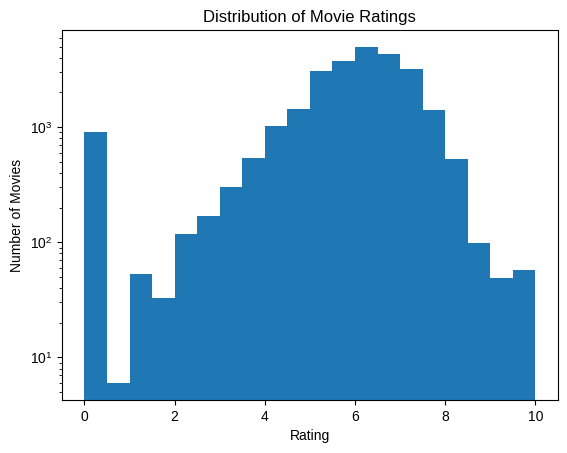

In [6]:
# Plot a histogram of the movie ratings from the IMDb dataset.
plt.hist(df_movies['vote_average'], bins=20)
plt.style.use('seaborn')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.yscale('log')
plt.show()

#### Process the genres

We reduced the number of genre to 41 grouping them into "main genres" and keeping only the most interesting ones.

In [7]:
dict_similar = {
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism"], 
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film", "race movie", "samurai cinema"],
    "Adventure": ["Adventure", "travel"],
    "Animals": ["Animal Picture"],
    "Anime": [],
    "Alien Film": ["Alien invasion"],
    "Animation": ["Animated cartoon"],
    "Beach Film": ["Beach Party film"],
    "Biographical film": ["Biography", "Biopic [feature]"],
    "Buddy film": ["Buddy Picture", "Buddy cop"],
    "Coming of age": ["Coming-of-age film"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comdedy", "Adventure Comedy", "Commedy of manners", "Workplace comedy", "comedy-drama"], 
    "Crime": ['crime', 'crime fiction', 'crime thriller', "master criminal films", "detective"],
    "Documentary": ["Political Documetary", "Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire"], 
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities'], 
    "Family": ["Family Film"],
    "Fiction": ["fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural"],
    "Gross out": ["Gross-out Film"],
    "Historical": ["history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries"],
    "Monster": ["Creature Movie", "Monster Movie", "Creature"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror"],
    "Indie": ["Indie"],
    "Language & Literature": ["& Literature"], 
    "LGBT": ["New Queer Cinema", "Gay", "Homoeroticism"],
    "Old movies": ["Silent film", "black-and-white"],
    "Parody": [],
    "Political cinema": ["Political Documentary"],
    "Prison": ["Prison film", "Women in prison film"],
    "Master Criminal Films": ["Heist", "Gangster Film"],
    "Music": ["Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical"],
    "For children": ["Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family"],
    "Religious Film": ["Christian film", "Cult"],
    "Romance": ["Romance film", "romantic fantasy"],
    "Sport": ["baseball", "boxing", "sports"],
    "Super hero": ["superhero movie", "superhero"],
    "Social issues": ["Social problem film"], 
    "Television Movie": ["TV Movie"],
    "Thriller": ["erotic thriller", "film à clef", "mystery", "suspense"],
    "War film": ["war", "War effort", "The Netherlands in World War II", "Gulf War", "Combat Films", "movies about gladiators", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies"],
    "Zombie": ["Zombie film", "Z-movie", "z movie"]
}

dict_similar_rev = dict()
for key, value in dict_similar.items():
    key = key.lower()
    for v in value:
        v = v.lower()
        dict_similar_rev[v] = key
    dict_similar_rev[key] = key

def get_genre(set_genres):
    new_genres = set()
    for g in set_genres:
        g = g.lower()
        temp = True
        for s_g in g.split(" "):
            if s_g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[s_g])
                temp = False
        if temp:
            if g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[g])
            # else:
            #     new_genres.add(g)

    return new_genres

df_movies["genres"] = df_movies["genres"].apply(get_genre)

In [8]:
all_genres = set()

for genres in df_movies["genres"]:
    all_genres.update(genres)

print("We have in total", len(all_genres), "different genres")
print(sorted(list(all_genres)))

We have in total 42 different genres
['action', 'adventure', 'alien film', 'animals', 'animation', 'anime', 'beach film', 'biographical film', 'buddy film', 'comedy', 'coming of age', 'crime', 'documentary', 'drama', 'family', 'fiction', 'for children', 'gross out', 'historical', 'horror', 'indie', 'language & literature', 'lgbt', 'master criminal films', 'monster', 'music', 'old movies', 'parody', 'political cinema', 'porn', 'prison', 'religious film', 'romance', 'social issues', 'sport', 'super hero', 'television movie', 'thriller', 'war film', 'western', 'world cinema', 'zombie']


In [9]:
# Create a column for each genre
for genre in all_genres:
    df_movies[f"is_{genre}"] = df_movies["genres"].apply(lambda x: genre in x)

### General analysis

#### Top and worst genres of all time

In [10]:
# genre rating
genre_rates = dict()
for genre in all_genres:
    g_rates = df_movies[df_movies[f"is_{genre}"]]["vote_average"].values
    if len(g_rates) < 100:
        continue
    ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
    genre_rates[genre] = np.mean(g_rates), ci.low, ci.high, g_rates



In [11]:
print(genre_rates["animation"])

(6.340318524727578, 6.2604475129226556, 6.40470513700949, array([6.7, 6.1, 5.4, ..., 7.5, 7. , 6.6]))


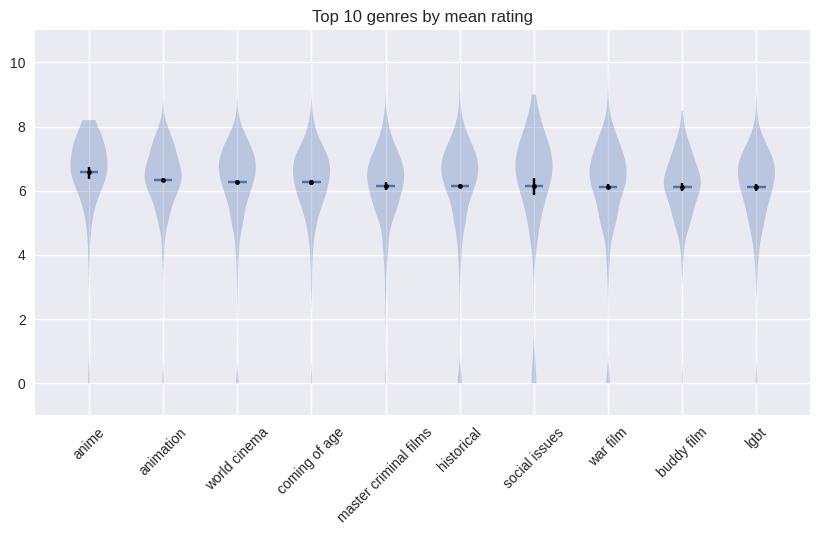

In [12]:
# Plot the top 10 genres
top10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=True)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
# plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
plt.errorbar(list(range(1, 11)), [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='.', color='black')
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Top 10 genres by mean rating")
plt.show()


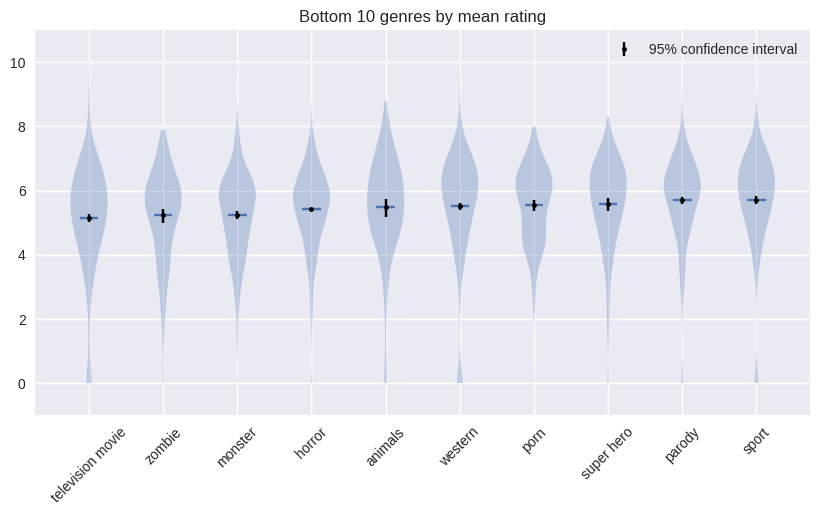

In [13]:
# Plot the bottom 10 genres
bottom10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=False)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in bottom10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in bottom10])
# plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
plt.errorbar(list(range(1, 11)), [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='.', color='black', label="95% confidence interval")
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Bottom 10 genres by mean rating")
plt.legend()
plt.show()


#### Evolution over time

Here is the code of a widget that helped us visualizing the evolution of most/worst popular genres over years. The widget shows the top 10 and bottom 10 genre over years.

Nevertheless we cannot play with this widget without running the code. As a compensation, here are some example of what we noticed.

In [14]:
# Genre rating by year
genre_rates_by_year = dict()
for year in tqdm(range(1900, 2020)):
    genre_rates_by_year[year] = dict()
    for genre in all_genres:
        g_rates = df_movies[(df_movies[f"is_{genre}"]) & (df_movies["year"] <= year)]["vote_average"].values
        if len(g_rates) < 100:
            continue
        ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
        genre_rates_by_year[year][genre] = np.mean(g_rates), ci.low, ci.high, g_rates

100%|██████████| 120/120 [02:59<00:00,  1.50s/it]


In [15]:
# Plot the top 10 genres by year
widget = widgets.IntSlider(min=1950, max=2019, step=1, value=1950)
def plot_top10_by_year(year):
    top10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=True)[:10]
    plt.figure(figsize=(10, 5))
    plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
    # plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
    # plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
    plt.errorbar([x[0] for x in top10], [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='o', color='black')
    plt.xticks(rotation=45)
    plt.ylim(-1, 11)
    plt.title(f"Top 10 genres by average rating in {year}")
    plt.show()

widgets.interact(plot_top10_by_year, year=widget)


interactive(children=(IntSlider(value=1950, description='year', max=2019, min=1950), Output()), _dom_classes=(…

<function __main__.plot_top10_by_year(year)>

In [16]:
# Plot the bottom 10 genres by year
widget = widgets.IntSlider(min=1920, max=2013, step=1, value=2013, description="Year:")
def plot_genre_by_year(year):
    bottom10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=False)[:10]
    plt.figure(figsize=(10, 5))
    plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
    plt.errorbar([x[0] for x in bottom10], [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='o', color='black', label="95% confidence interval")
    plt.xticks(rotation=45)
    plt.title(f"Bottom 10 genres by average rating in {year}")
    plt.legend()
    plt.show()

widgets.interact(plot_genre_by_year, year=widget)


interactive(children=(IntSlider(value=2013, description='Year:', max=2013, min=1920), Output()), _dom_classes=…

<function __main__.plot_genre_by_year(year)>

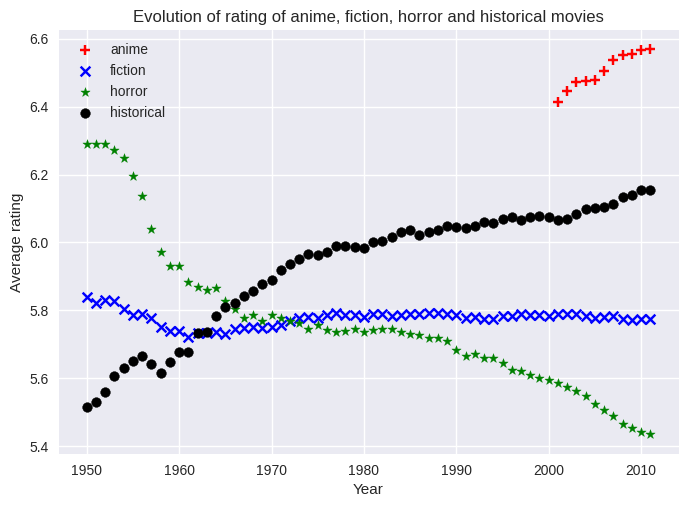

In [17]:
# Plot evolution of rating for some genres
for year in range(1950, 2012):
    if year not in genre_rates_by_year:
        continue
    if "anime" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["anime"][0], color="red", label="anime" if year == 2011 else None, marker="+")
    if "fiction" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["fiction"][0], color="blue", label="fiction" if year == 2011 else None, marker="x")
    if "horror" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["horror"][0], color="green", label="horror" if year == 2011 else None, marker="*")
    if "historical" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["historical"][0], color="black", label="historical" if year == 2011 else None, marker="o")

plt.title("Evolution of rating of anime, fiction, horror and historical movies")
plt.ylabel("Average rating")
plt.xlabel("Year")
plt.legend()
plt.show()

In [31]:
# Create an interactive plot of the evolution of rating with chosen genres
import json
from ipywidgets.embed import embed_data

# Take all the possible genres from all years
genres = set()
for year in genre_rates_by_year:
    genres.update(genre_rates_by_year[year].keys())

genres = list(genres)

widget = widgets.SelectMultiple(options=genres, value=genres, description="Genres:")
def plot_genre_evolution(genres):
    genre_rates = dict()
    for genre in genres:
        rates = []
        for year in range(1950, 2012):
            if year not in genre_rates_by_year:
                continue
            if genre in genre_rates_by_year[year]:
                rate = genre_rates_by_year[year][genre][0]
                rates.append((year, rate))
        # Plot the rate as a function of the year for the genre
        plt.plot([x[0] for x in rates], [x[1] for x in rates], label=genre)
        genre_rates[genre] = rates
    
    # # Save the data to json
    # with open("genre_rates.json", "w") as f:
    #     json.dump(genre_rates, f)

    # plt.title("Evolution of rating of chosen genres")
    # plt.ylabel("Average rating")
    # plt.xlabel("Year")
    # plt.legend()
    # plt.show()

widgets.interact(plot_genre_evolution, genres=widget)

interactive(children=(SelectMultiple(description='Genres:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_genre_evolution(genres)>

In this plot we can see the decline of fiction and horror movies. They were the moreliked movies in the middle of the 20th century. But in the last 50 years they became less popular, entering the bottom 10 of the most popular genres.

On the other hand we can see the rise of historical movies. They were not popular before the 80s but they became more and more popular in the last 50 years.

And at last, we see the very recent rise of anime movies. They were almost inexistant before the 2000s but they became very popular in the last 10 years and the most popular in 2011.

#### Common features of worst rated movies

In this section we try to find some common features of the worst rated movies. First, we split the movies into 3 categories: the worst rated movies, the best rated movies and the movies in the middle. Then we compare the features of the 3 categories.

##### Split

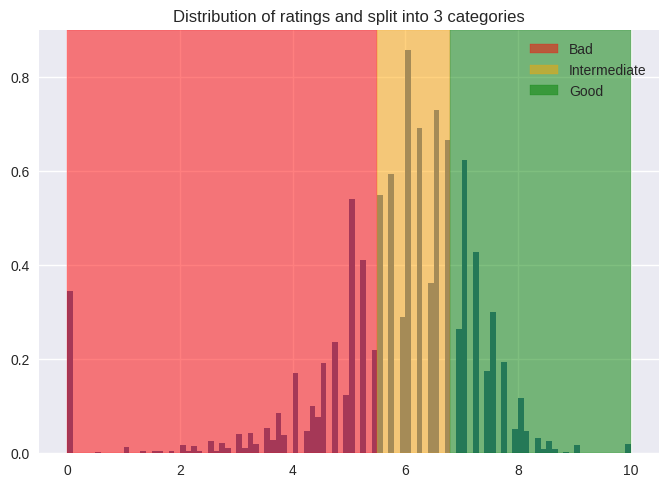

In [19]:
# Distribution of ratings
plt.hist(df_movies["vote_average"], bins=100, density=True)
# split into 3 categories
plt.axvspan(0, 5.5, alpha=0.5, color='red', label="Bad")
plt.axvspan(5.5, 6.8, alpha=0.5, color='orange', label="Intermediate")
plt.axvspan(6.8, 10, alpha=0.5, color='green', label="Good")
plt.legend()
plt.title("Distribution of ratings and split into 3 categories")
plt.show()

In [20]:
# Split the data into 3 groups
df_movies["rating_group"] = pd.cut(df_movies["vote_average"], bins=[0, 5.5, 6.8, 10], labels=["bad", "average", "good"])

# Print the number of movies in each group
df_movies["rating_group"].value_counts()

average    11543
bad         7528
good        6040
Name: rating_group, dtype: int64

##### Budget

What is the distribution of the budget in each category?

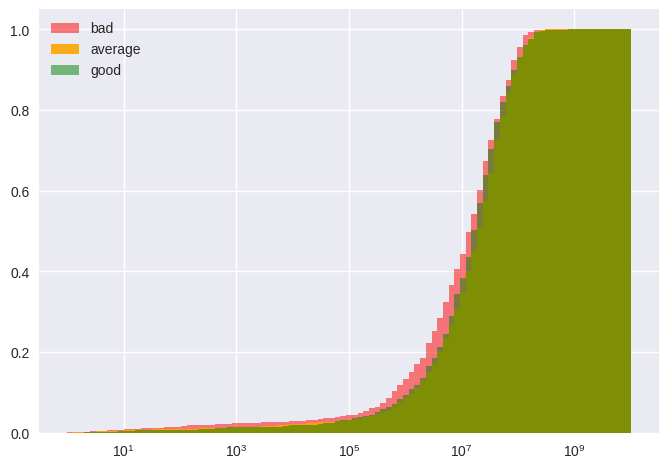

In [21]:
# Plot budget distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_budget"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5, color="red")
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_budget"], bins=bins, density=True, cumulative=True, label="average", alpha=0.9, color="orange")
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_budget"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.5, color="green")
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


While average and good moovies seems to have a similar distribution of budget, the worst movies have a lower budget. Let's confirm that with a t-test. 

In [22]:
ttest_results = ttest_ind(df_movies[df_movies["rating_group"] == "bad"]["adj_budget"].dropna(), df_movies[df_movies["rating_group"].isin(["good", "average"])]["adj_budget"].dropna())
print(f"Average budget for bad movies: {df_movies[df_movies['rating_group'] == 'bad']['adj_budget'].dropna().mean()}")
print(f"Average budget for other movies: {df_movies[df_movies['rating_group'].isin(['average', 'good'])]['adj_budget'].dropna().mean()}")
print("We can reject the null hypothesis that the average budget for bad movies is the same as for other movies with a p-value of", ttest_results.pvalue)

Average budget for bad movies: 6408717.0142129725
Average budget for other movies: 10101165.899562955
We can reject the null hypothesis that the average budget for bad movies is the same as for other movies with a p-value of 4.518123453696245e-21


##### Revenue

Intuitively, we expect the worst movies to have a lower revenue. Let's confirm that with a t-test.

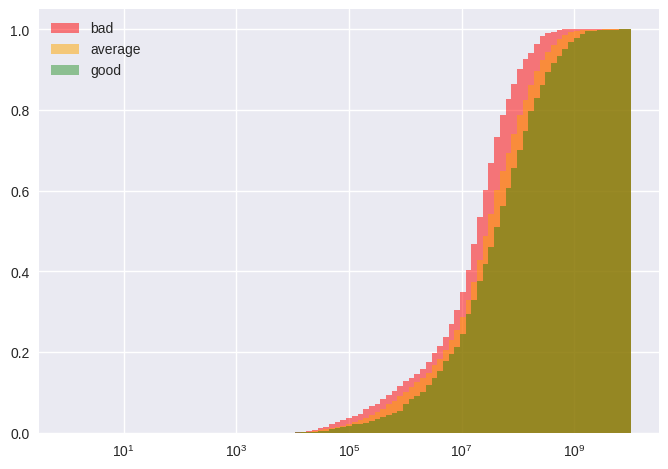

In [23]:
# Plot revenue distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5, color="red")
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="average", alpha=0.5, color="orange")
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_revenue_x"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.4, color="green")
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


In [24]:
ttest_results = ttest_ind(df_movies[df_movies["rating_group"] == "bad"]["adj_revenue_x"].dropna(), df_movies[df_movies["rating_group"].isin(["good", "average"])]["adj_revenue_x"].dropna())
print(f"Average revenue for bad movies: {df_movies[df_movies['rating_group'] == 'bad']['adj_revenue_x'].dropna().mean()}")
print(f"Average revenue for other movies: {df_movies[df_movies['rating_group'].isin(['average', 'good'])]['adj_revenue_x'].dropna().mean()}")
print("We can reject the null hypothesis that the average revenue for bad movies is the same as for other movies with a p-value of", ttest_results.pvalue)

Average revenue for bad movies: 47348298.762323886
Average revenue for other movies: 116510716.70810841
We can reject the null hypothesis that the average revenue for bad movies is the same as for other movies with a p-value of 3.9414645880489066e-23


#### The countries that have bad reviews

We would like to know where the worst movies are produced. Therefore we compute the average rating in each country and we represent the result in a map.

In [25]:
# Process the countries and languages columns
def process_countries_languages(x):
    if x is None or pd.isna(x):
        return []
    else:
        return list(json.loads(x).values())

df_movies["countries"] = df_movies["countries"].apply(process_countries_languages)
df_movies["languages"] = df_movies["languages"].apply(process_countries_languages)


In [26]:
# Another preprocessing step
countries_mapping = {
    "Palestinian territories": "Palestine",
    "Palestinian Territories": "Palestine",
    "West Germany": "Germany",
    "East Germany": "Germany",
    "Wales": "United Kingdom",
    "Korea": "South Korea",
    "Czechoslovakia": "Czech Republic",
    "Republic Democratic of the Congo": "Congo",
    "Kingdom of Great Britain": "United Kingdom",
    "Northern Ireland": "Ireland",
    "Republic of China": "China",
    "Slovak Republic": "Slovakia",
    "Georgian SSR": "Georgia",
    "Ukrainian SSR": "Ukraine",
    "German Democratic Republic": "Germany",
    "Kingdom of Italy": "Italy",
    "Mandatory Palestine": "Palestine"
}

def map_countries(x):
    return [x if x not in countries_mapping else countries_mapping[x] for x in x]

df_movies["countries"] = df_movies["countries"].apply(map_countries)

In [27]:
# Get all countries
all_countries = set()

for c in df_movies["countries"]:
    all_countries.update(c)

print("We have in total", len(all_countries), "different countries")
print(sorted(list(all_countries)))

We have in total 119 different countries
['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark', 'Egypt', 'England', 'Estonia', 'Ethiopia', 'Federal Republic of Yugoslavia', 'Finland', 'France', 'Georgia', 'German Language', 'Germany', 'Greece', 'Guinea', 'Haiti', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kenya', 'Kuwait', 'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mexico', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Nazi Germany', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Palestine

In [28]:
# Create a column for each country, language
for c in all_countries:
    df_movies[f"played_in_{c}"] = df_movies["countries"].apply(lambda x: c in x)

In [29]:
# Average rating by country
country_rates = dict()
for c in all_countries:
    c_rates = df_movies[df_movies[f"played_in_{c}"]]["vote_average"]
    if len(c_rates) < 10 or c_rates.mean() < 1:
        continue
    country_rates[c] = c_rates

min_rating = min([country_rates[c].mean() for c in country_rates])
max_rating = max([country_rates[c].mean() for c in country_rates])

# Normalize the ratings
normalized_country_rates = dict()
for c in country_rates:
    normalized_country_rates[c] = (country_rates[c].mean() - min_rating) / (max_rating - min_rating)



AttributeError: 'ListedColormap' object has no attribute 'resampled'

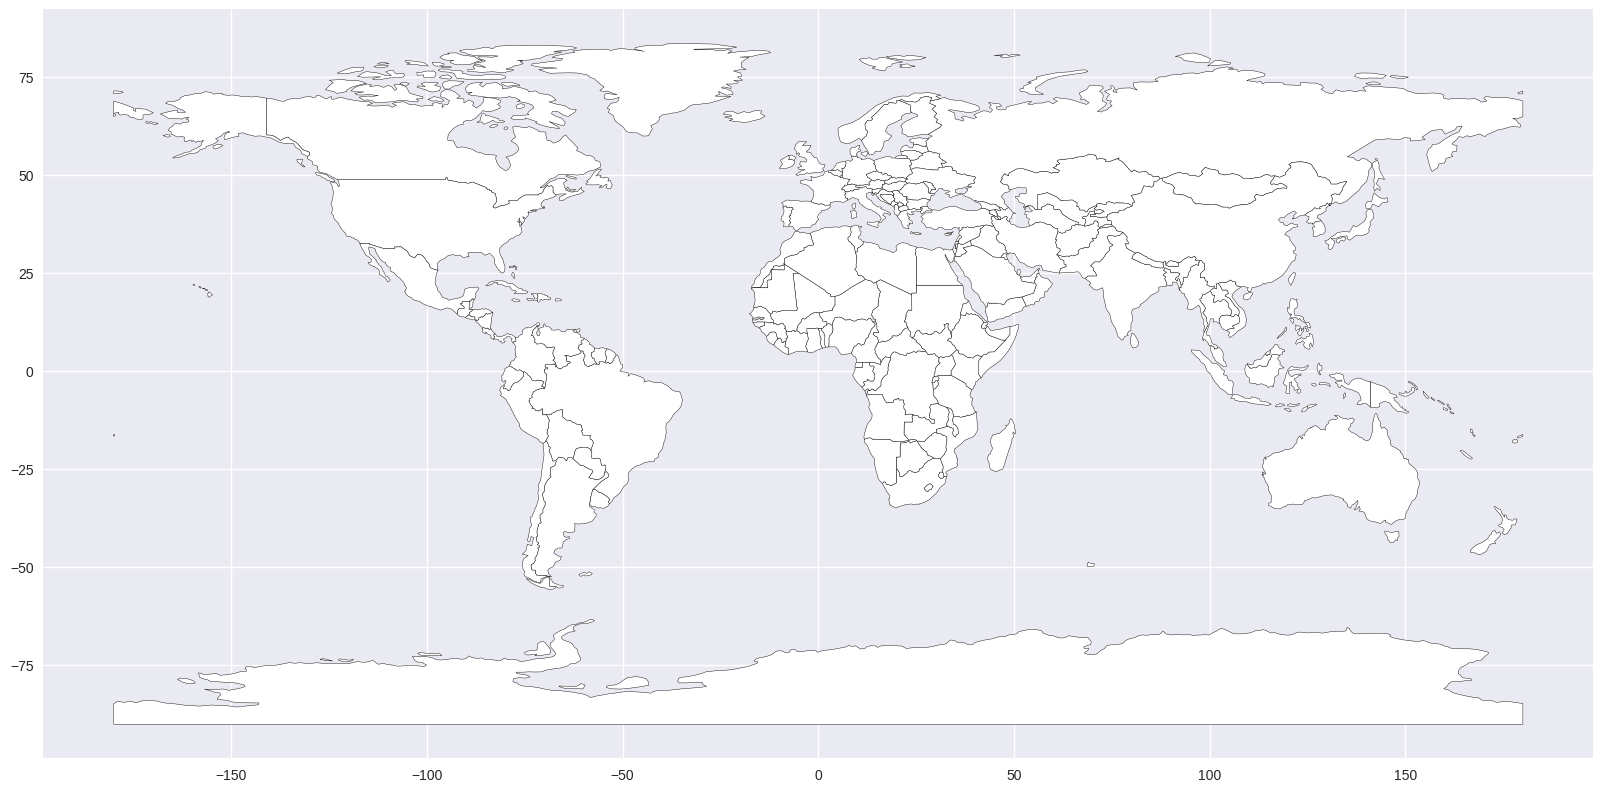

In [30]:
# World map coloured by vote average
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 10), color="white", edgecolor="black")

cmap = matplotlib.colormaps["plasma"].resampled(100)

for c in normalized_country_rates:
    c_rate = normalized_country_rates[c]
    if c not in world.name.values:
        continue
    world[world.name == c].plot(color=cmap(c_rate),ax=ax)
for c in world.name.values:
    if c not in normalized_country_rates:
        world[world.name == c].plot(color="white",ax=ax)
# plt.set_cmap("plasma")
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(min_rating, max_rating), cmap=cmap),
             ax=ax, label="Average rating")
plt.show()

Same thing but with group by region.

In [ ]:
continent_mapping = {
    "Europe": {"France",  # <3
               "Spain",  # <3
               "Finland",  # <3
               "Albania", "Aruba", "Austria", "Belgium", "Bosnia and Herzegovnia", "Bulgaria", "Croatia", "Czech Republic", "Denmark", "England", "Estonia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Russia", "Scotland", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "United Kingdom", "Vatican City", "Federal Rrepublic of Yugoslavia", "Yugoslavia", "Republic of Macedonia", "Soviet Union", "Bosnia and Herzegovina", "Nazi Germany", "Socialist Federal Republic of Yugoslavia", "Isle of Man", "Weimar Republic", "Federal Republic of Yugoslavia", "Serbia and Montenegro", "German Language"},
    "North America": {"Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "El Salvador", "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States of America", "United States Virgin Islands", "United States", "Puerto Rico"},
    "Middle East": {"Cyprus", "Egypt", "Iran", "Israel", "Kuwait", "Lebanon", "Oman", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen", "Palestine"},
    "Asia": {"Afghanistan", "Armenia", "Azerbaijan", "Bangladesh", "Bhutan", "Cambodia", "China", "Georgia", "India", "Indonesia", "Iraq", "Japan", "Hong Kong", "Jordan", "Malaysia", "Mongolia", "Pakistan", "Philippines", "Singapore", "South Korea", "Sri Lanka", "Taiwan", "Thailand", "Vietnam",  # <3
             "Uzbekistan"},
    "South America": {"Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"},
    "Oceania": {"Australia", "Fiji", "New Zealand", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Vanuatu"},
    "Africa": {"Algeria", "Burkina Faso", "Cameroon", "Congo", "Democratic Republic of the Congo", "Egypt", "Ethiopia", "Ghana", "Guinea", "Kenya", "Liberia", "Libya", "Madagascar", "Mali", "Mauritania", "Morocco", "Niger", "Nigeria", "Rwanda", "Senegal", "Sierra Leone", "Somalia", "South Africa", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"},
}
inv_continent_mapping = dict()
for k, v in continent_mapping.items():
    for c in v:
        inv_continent_mapping[c] = k

# Create a column for each continent
for c in continent_mapping:
    df_movies[f"played_in_{c}"] = df_movies["countries"].apply(lambda x: any([c == inv_continent_mapping[y] for y in x]))

continent_mapping["Asia"].update(continent_mapping.pop("Middle East"))


In [ ]:
# Average rating by continent
region_rates = dict()
for c in continent_mapping:
    for country in continent_mapping[c]:
        if country not in country_rates:
            continue
        if c not in region_rates:
            region_rates[c] = []
        region_rates[c].append(country_rates[country].mean())
for c in continent_mapping:
    region_rates[c] = np.mean(region_rates[c])

min_rating = min([region_rates[c] for c in continent_mapping])
max_rating = max([region_rates[c] for c in continent_mapping])

# Normalize the ratings
normalized_region_rates = dict()
for c in region_rates:
    normalized_region_rates[c] = (region_rates[c] - min_rating) / (max_rating - min_rating)


['Oceania' 'Africa' 'North America' 'Asia' 'South America' 'Europe'
 'Seven seas (open ocean)' 'Antarctica']


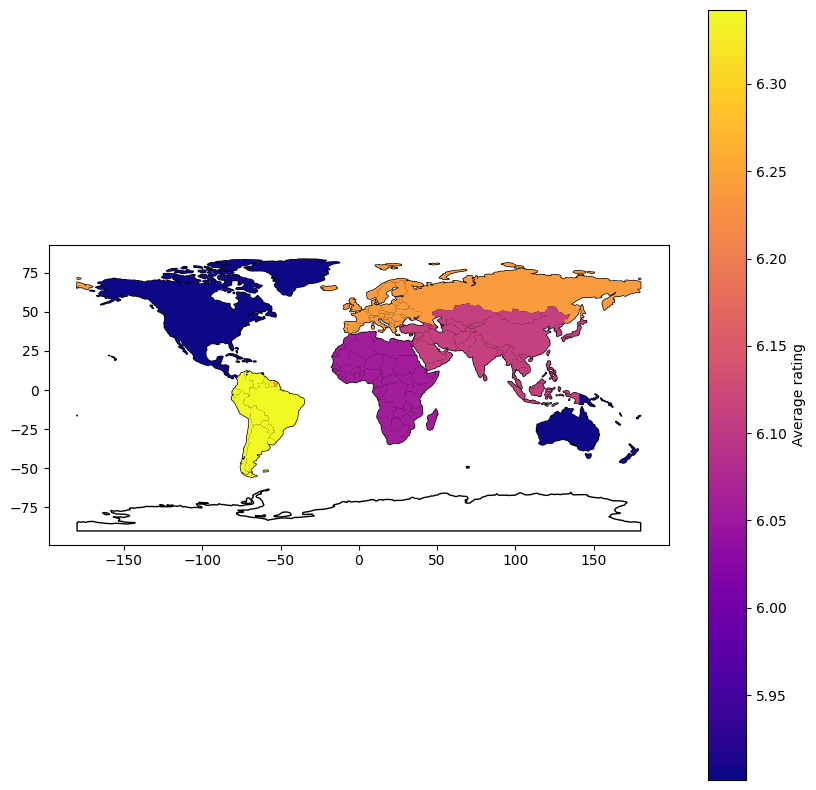

In [ ]:
# World map coloured by vote average
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
print(world.continent.unique())
ax = world.plot(figsize=(10, 10), color="white", edgecolor="black")

for c in region_rates:
    r_rate = normalized_region_rates[c]
    if c not in world.continent.values:
        continue
    world[world.continent == c].plot(color=cmap(r_rate),ax=ax)
for c in world.continent.values:
    if c not in region_rates:
        continue
        world[world.name == c].plot(color="white",ax=ax)

plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(min_rating, max_rating), cmap=cmap),
             ax=ax, label="Average rating")
plt.show()

#### So can we predict the rating of a movie?

With all the features we have explored so far: budget, revenue, genre, country, we can try to predict the rating of a movie. With the one hot encoding of the genre and continent, we have 2 + 41 + 6 = 49 features.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def get_data(features_name, target_name):
    all_features = features_name + [target_name]
    data = df_movies[all_features].dropna()
    print(f"Total number of movies: {len(data)}")
    print(f"Number of features: {len(features_name)}")
    return data[features_name], data[target_name]

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of test samples: {len(X_test)}")
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_linear_model(X_train, y_train):
    X_train = sm.add_constant(X_train)
    X_train = np.float32(X_train)
    model = sm.OLS(y_train, X_train, missing='drop')
    results = model.fit()
    return results

def evaluate_model(model, X_test, y_test):
    score = model.score(X_test, y_test)
    print(f"R squared: {score}")



In [ ]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
target_name = "vote_average"

X, y = get_data(features_name, target_name)
X_train, X_test, y_train, y_test = split_data(X, y)
basic_model = train_model(X_train, y_train)
evaluate_model(basic_model, X_test, y_test)
mse_1 = (y_test - basic_model.predict(X_test)) ** 2

Total number of movies: 6883
Number of features: 52
Number of training samples: 5506
Number of test samples: 1377
R squared: 0.21595810129672222


So we got a $R^2$ of 0.2 of the test set that is not really high. If we want to explain the rating of a movie, we need to find more features.

### Feature extraction

#### Competition effect

It is intuitive to believe that the competition bewteen movies has an effect on the success or failure of a movie. But what is the competition?

The features related to competition we extract are :
 - the number of movies released the same week
 - the number of movies released the same month
 - the number of movies released the same year

 - the number of movies released the same week of the same genre
 - the number of movies released the same month of the same genre
 - the number of movies released the same year of the same genre

In [ ]:
# Only keep movies with a release date
df_movies = df_movies.dropna(subset=["release_date"])

# Count the number of movies per week, month, year 
for period in ["W", "M", "Y"]:
    df_movies["period"] = df_movies["release_date"].apply(lambda x: x.to_period(period))
    mapping = df_movies.groupby("period")["period"].count().to_dict()
    df_movies["num_release_this_" + period] = df_movies["period"].apply(lambda x: mapping[x] if x in mapping else 0)
df_movies.drop(columns=["period"], inplace=True)

# Count the number of movies per week, month, year of the same genre
for period in ["W", "M", "Y"]:
    df_movies["num_release_this_" + period + "_of_same_genre"] = 0
    df_movies["period"] = df_movies["release_date"].apply(lambda x: x.to_period(period))
    for g in all_genres:
        df_movies.groupby("period")[f"is_{g}"].sum()
        mapping = df_movies.groupby("period")[f"is_{g}"].sum().to_dict()
        df_movies[f"num_release_this_{period}_of_same_genre"] += df_movies["period"].apply(lambda x: mapping[x] if x in mapping else 0)
df_movies.drop(columns=["period"], inplace=True)



Let's first see the correlation between each new feature and the rating.

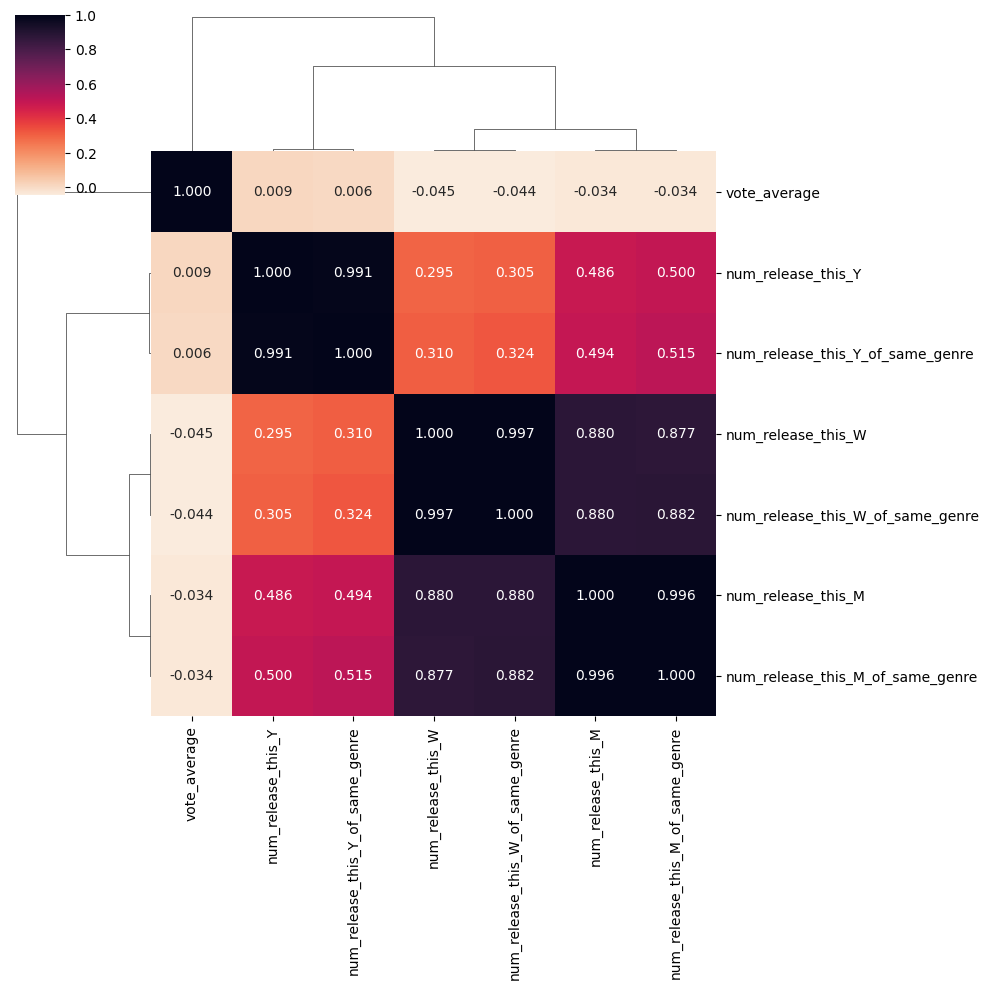

In [ ]:
sns.clustermap(df_movies[["num_release_this_W", "num_release_this_M", "num_release_this_Y",
           "num_release_this_W_of_same_genre", "num_release_this_M_of_same_genre", "num_release_this_Y_of_same_genre",
           "vote_average"]].corr(), cmap="rocket_r", annot=True, fmt=".3f")

So we can see that grouping by genre is not really useful the values are very correlated with the non grouped values. We will only use the non grouped values.

Then we can see that the number of movies released the same week, month or year are not highly correlated with the rating. Nevertheless we can still note the negative correlation between the number of movies released the same week or month and the rating. On the contrary the number of movies released the same year is positively correlated with the rating. 


In [ ]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
features_name += ["num_release_this_W", "num_release_this_M", "num_release_this_Y"]
target_name = "vote_average"

X, y = get_data(features_name, target_name)
X_train, X_test, y_train, y_test = split_data(X, y)
competition_model = train_model(X_train, y_train)
evaluate_model(competition_model, X_test, y_test)


Total number of movies: 6883
Number of features: 55
Number of training samples: 5506
Number of test samples: 1377
R squared: 0.2210244810803622


We improved the $R^2$ of our model by 0.01 (+5%) adding the competition features.

### Initial analysis of tvtropes effect

For this part, the goal is to explore the associations between the presence of tropes and the indication of box-office bombs. This could be done by doing a logistic regression of the `is_bomb_tvtropes` variable on the one-hot encodings of the tropes and look at the coefficients and the p-values.

In [ ]:
# Retrieve all the tropes from the movies in the dataset
all_tropes = [tr for tropes in df_tropes["trope"].values for tr in tropes if tr != "boxofficebomb"]
# Retrieve all  the tropes from the box-office bomb movies in the dataset
all_tropes_bombs = [tr for tropes in df_tropes["trope"].values for tr in tropes if "boxofficebomb" in tropes and tr != "boxofficebomb"]

# counts the number of movies in each trope
from collections import Counter
counts = Counter(all_tropes)
counts_bombs = Counter(all_tropes_bombs) # only consider bombs

def normalize_counts(counts, normalizing_const=None):
    """Divide the counts by the number of movies
    """
    if normalizing_const is None:
        normalizing_const = sum(counts.values(), 0.0)
    for key in counts:
        counts[key] /= normalizing_const
        counts[key] *= 100
    return counts

def count_movies_with_trope_is_bomb(df_tropes, trope):
    i = 0
    for trope_list in df_tropes["trope"]:
        if trope in trope_list and "boxofficebomb" in trope_list:
            i += 1
    return i

# normalize by the number of movies
counts_n = normalize_counts(counts, df_tropes.shape[0])
counts_bombs_n = normalize_counts(counts_bombs, df_tropes["is_bomb_tvtropes"].sum())

res_all = {}
for k, v in counts.most_common(100):
    res_all[k] = v

top_tropes = list(res_all.keys())

res_bombs = {}
for k, v in counts_bombs.most_common(100):
    res_bombs[k] = v

In [ ]:
dict_plot = {}
for i, trope in enumerate(top_tropes):
    dict_plot[trope] = count_movies_with_trope_is_bomb(df_tropes, trope) / res_all[trope]
dict_plot = {k: v for k, v in sorted(dict_plot.items(), key=lambda item: item[1], reverse=True)}

plt.bar(list(dict_plot.keys())[:10], list(dict_plot.values())[:10])
plt.xticks(rotation=90)
plt.ylabel("% of all movies with the trope")
plt.title("% of bombed movies in each of the top tropes")
plt.show()

Comment: These tropes are the ones that contain the most bombed movies. We can see that these tropes make a lot of sense when one checks their definitions on tvtropes.org.

In [ ]:
features_list = top_tropes

trope_ind_mat = np.zeros((len(df_tropes), len(features_list)))

for i, trope in enumerate(features_list):
    trope_indicator = []
    for trope_list in df_tropes["trope"].values:
        trope_indicator.append(trope in trope_list)
    trope_ind_mat[:, i] = trope_indicator
trope_ind_mat = pd.DataFrame(trope_ind_mat, columns=features_list)

model = sm.Logit(df_tropes["is_bomb_tvtropes"].values, sm.add_constant(trope_ind_mat))
res = model.fit()

res.params[res.pvalues[res.pvalues < 0.05/100].index].sort_values(ascending=False)

Unhide the cell below to see the full results of the regression. In short, there are a few tropes that have strong effects (possibly causal) on the failure of the movie, but these tropes are not present in the trope plot above.

#### Full results of the regression

In [ ]:
res.summary()

### What about actors


In [ ]:
df_actors = get_characters()
df_actors = df_actors.merge(df_movies[["wiki_id", "vote_average"]], on="wiki_id") 
df_actors = df_actors[df_actors["vote_average"] > 0]

Let's see if the relationship between ratings and actors career i.e. the number of movies they have played in.

Text(0.5, 1.0, 'Number of movies actors played in vs. average rating of their movies')

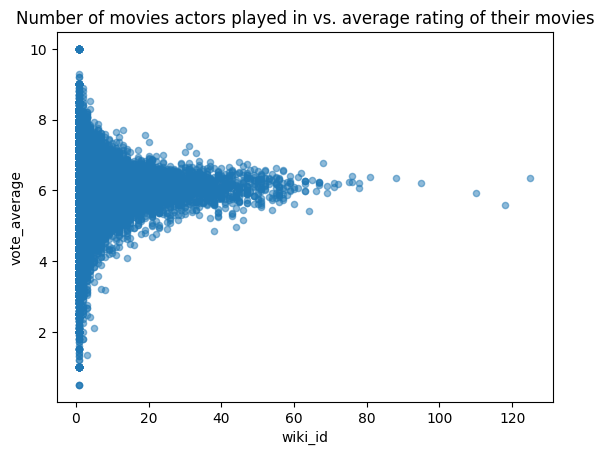

In [ ]:
df_actors_grouped = df_actors.groupby(["actor_name", "actor_dob"])
df_actors_grouped = df_actors_grouped.agg({"vote_average": "mean", "wiki_id": "count"})
df_actors_grouped.plot(kind="scatter", x="wiki_id", y="vote_average", alpha=0.5)
plt.title("Number of movies actors played in vs. average rating of their movies")

With the previous plot, we can see that actors who have played mostly in very good movies or very bad movies, tend to end their career more quickly. But actors that have played in movies with a rating in the middle, tend to have a longer career.

Plotting the minimum rating of the movies they have played in, we can see that it is not rare for actors to have played in a movie with a very bad rating. Therefore it does not necessarily put an end to their career.

Text(0.5, 1.0, 'Number of movies actors played in vs. rating of their worst movies')

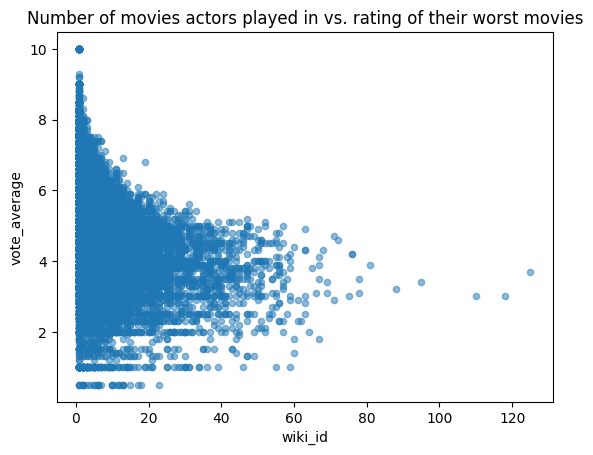

In [ ]:
df_actors_grouped = df_actors.groupby(["actor_name", "actor_dob"])
df_actors_grouped = df_actors_grouped.agg({"vote_average": "min", "wiki_id": "count"})
df_actors_grouped.plot(kind="scatter", x="wiki_id", y="vote_average", alpha=0.5)
plt.title("Number of movies actors played in vs. rating of their worst movies")